In [188]:
import soundfile as sf
import numpy as np

noisy_sensor_tuple = sf.read('resources/noisySensor.wav')

In [189]:
sampling_rate = noisy_sensor_tuple[1]

In [190]:
noisy_sensor_data = noisy_sensor_tuple[0]
noisy_sensor_data

array([[ 0.00793457,  0.03259277, -0.00076294,  0.0027771 ],
       [ 0.00717163, -0.01785278,  0.00039673,  0.0300293 ],
       [ 0.00408936, -0.00509644, -0.00576782, -0.00244141],
       ...,
       [-0.01037598,  0.00057983, -0.02798462, -0.01687622],
       [ 0.00997925, -0.00830078,  0.00979614, -0.02633667],
       [-0.02468872, -0.01419067,  0.00164795, -0.00024414]])

In [191]:
noisy_sensor_data.shape

(109466, 4)

In [192]:
frame_length = 128
frame_shift = 32
frame_length_samples = frame_length * sampling_rate / 1000

In [193]:
def my_windowing(v_signal: np.ndarray, sampling_rate: int, frame_length: int, frame_shift: int) -> [np.ndarray, np.ndarray]:
    millis_per_sample = 1000 / sampling_rate
    frame_length_num_points = frame_length / millis_per_sample
    frame_shift_num_points = frame_shift / millis_per_sample
    num_frames = int(np.floor((len(v_signal) - frame_length_num_points) / frame_shift_num_points) + 1)
    m_frames = np.zeros((num_frames, int(frame_length_num_points)))
    v_time_frame = np.zeros(num_frames)
    for i in range(num_frames):
        start = int(i * frame_shift_num_points)
        end = int(i * frame_shift_num_points + frame_length_num_points)
        m_frames[i] = v_signal[start:end]
        v_time_frame[i] = (start + end)/(2*sampling_rate)
    return [m_frames, v_time_frame]

In [194]:
def compute_freq_axis(m_stft: np.ndarray):
    return np.linspace(0, sampling_rate//2, num=m_stft.shape[1])

def remove_upper_half_spectrum(m_stft: np.ndarray) -> np.ndarray:
    m_stft_new = m_stft[:, :(int(m_stft.shape[1]/2)+1)]
    return m_stft_new

In [195]:
def compute_stft(v_signal: np.ndarray, fs: int, frame_length: int, frame_shift: int, v_analysis_window: np.ndarray) -> [np.ndarray, np.ndarray, np.ndarray]:
    m_frames, v_time_frame = my_windowing(v_signal, fs, frame_length, frame_shift)
    m_stft_full = np.zeros(m_frames.shape, dtype=np.complex128)
    #v_analysis_window = v_analysis_window(m_frames.shape[1])
    for i in range(m_frames.shape[0]):
        m_stft_full[i] = np.fft.fft(m_frames[i]*v_analysis_window)
    #v_freq = np.fft.rfftfreq(m_stft_full.shape[1], 1/fs)
    m_stft = remove_upper_half_spectrum(m_stft_full)
    v_freq = compute_freq_axis(m_stft)
    return [m_stft, v_freq, v_time_frame]

In [196]:
from scipy.signal import get_window

hann_window = get_window('hann', int(frame_length_samples), fftbins=True)
root_hann = np.sqrt(hann_window)
analysis_window = root_hann
synthesis_window = root_hann*0.5

In [197]:
noisy_sensor_data[:, 1]

array([ 0.03259277, -0.01785278, -0.00509644, ...,  0.00057983,
       -0.00830078, -0.01419067])

In [198]:
m_stft_all, v_freq_all, v_time_frame_all = list(), list(), list()

for i in range(noisy_sensor_data.shape[1]):
    m_stft, v_freq, v_time_frame = compute_stft(noisy_sensor_data[:, i], sampling_rate, frame_length, frame_shift, analysis_window)
    m_stft_all.append(m_stft)
    v_freq_all.append(v_freq)
    v_time_frame_all.append(v_time_frame)

m_stft_all = np.array(m_stft_all)
v_freq_all = np.array(v_freq_all)
v_time_frame_all = np.array(v_time_frame_all)

2.2) The synthesis window is multiplied by one half to compensate for the overlap of the windows. The synthesis window is then applied to the STFT of the noisy signal to obtain the reconstructed signal.

In [199]:
def compute_time_delay(d, i, theta):
    c = 340
    t = i*d*np.cos(theta) / c
    return t

In [200]:
theta = np.pi/4
d = 0.05
ts = np.array([compute_time_delay(d, i, theta) for i in range(noisy_sensor_data.shape[1])])
ts

array([0.        , 0.00010399, 0.00020797, 0.00031196])

In [201]:
v_freq_all.shape[1]

1025

It is the correct formula because there is a right angle can be projected between two sensors and then we can calculate the time difference using triangulation.

In [202]:
def compute_steering_vector(sampling_rate, t):
    N = v_freq_all.shape[1]
    a = np.zeros((N, 4), dtype=np.complex128)
    for k in range(N):
        a[k][0] = 1
        for i in range(1, 4):
            a[k][i] = np.exp((-1j*2*np.pi*k*sampling_rate*t[i])/N)
    return a

In [214]:
a = compute_steering_vector(sampling_rate, ts)
a

array([[ 1.        +0.j        ,  1.        +0.j        ,
         1.        +0.j        ,  1.        +0.j        ],
       [ 1.        +0.j        ,  0.99994799-0.01019869j,
         0.99979197-0.02039633j,  0.99953196-0.03059184j],
       [ 1.        +0.j        ,  0.99979197-0.02039633j,
         0.99916798-0.04078417j,  0.99812828-0.06115504j],
       ...,
       [ 1.        +0.j        , -0.54159111+0.84064206j,
        -0.41335814-0.91056853j,  0.9893333 +0.14566959j],
       [ 1.        +0.j        , -0.53298949+0.84612186j,
        -0.4318444 -0.90194812j,  0.99332655+0.11533589j],
       [ 1.        +0.j        , -0.52433244+0.85151365j,
        -0.45015099-0.89295245j,  0.99638997+0.08489422j]])

In [204]:
m = noisy_sensor_data.shape[1]
ah = np.conjugate(a).T
ah.shape

(4, 1025)

In [205]:
m_stft_all.shape

(4, 210, 1025)

In [206]:
b = m_stft_all.reshape(1025, 4, 210)
b.shape

(1025, 4, 210)

In [207]:
s = np.zeros((b.shape[0], b.shape[2]), dtype=np.complex128)
s.shape

(1025, 210)

In [208]:
aht = ah.T
aht.shape

(1025, 4)

In [218]:
b[0]

array([[-2.14441788e-01+0.00000000e+00j, -1.02011278e-01+6.56959627e-02j,
         2.33770241e-02-2.70940869e-01j,  3.21514384e-01+6.85241429e-01j,
         1.03354027e-01-7.07017842e-01j, -2.52430580e-01+2.12915973e-01j,
        -1.85449547e-01+4.41030047e-01j,  2.90715095e-01-3.66688493e-01j,
        -3.37216057e-01+2.26293576e-02j, -1.17440263e-01+2.50308229e-01j,
         1.11038392e-01-5.39548585e-01j,  5.14484222e-02+6.70134081e-01j,
         6.30693969e-01-1.56953176e-01j, -2.75920075e-02-2.89160845e-01j,
        -6.32129180e-01-4.58681608e-01j,  8.33687906e-01+5.27017652e-02j,
        -4.14963886e-01+4.60530143e-01j, -2.25109236e-01+3.77693710e-01j,
        -3.58319393e-01+4.32807283e-01j,  4.27183620e-01-9.23941890e-01j,
        -8.47262296e-02+4.63333633e-01j, -2.75949832e-01-9.59212578e-01j,
         4.78062210e-01+6.35936053e-01j,  7.43994641e-04-3.64557192e-01j,
        -7.56384885e-02+3.84478762e-01j,  5.44659285e-02+4.41026428e-01j,
         1.41759829e-01+5.61878180e-03

In [223]:
for k in range(b.shape[0]):
    s[k] = aht[k] @ b[k,:,:]
    #for l in range(b.shape[2]):
        #print(f"{aht[k].shape=}")
        #print(f"{b[k,:,l].shape=}")
        #print(f"{(aht[k] @ b[k,:,l])=}")
        #s[k,l] = np.sum(aht[k] * b[k,:,l])
s.shape

(1025, 210)

In [224]:
import matplotlib.pyplot as plt

def plot_spectrogram_nostft(m_stft, v_time_frame, v_freq, vmin=None, vmax=None):
    fig = plt.figure()
    fig.set_size_inches(26.5, 15.5)
    ax = fig.add_subplot(111)
    im = ax.imshow(10*np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10**(-15))),
                   cmap='viridis', origin='lower', extent=[v_time_frame[0], v_time_frame[-1], v_freq[0],
                                                           sampling_rate//2], aspect='auto', vmin=vmin, vmax=vmax)
    fig.colorbar(im, orientation="vertical", pad=0.2)

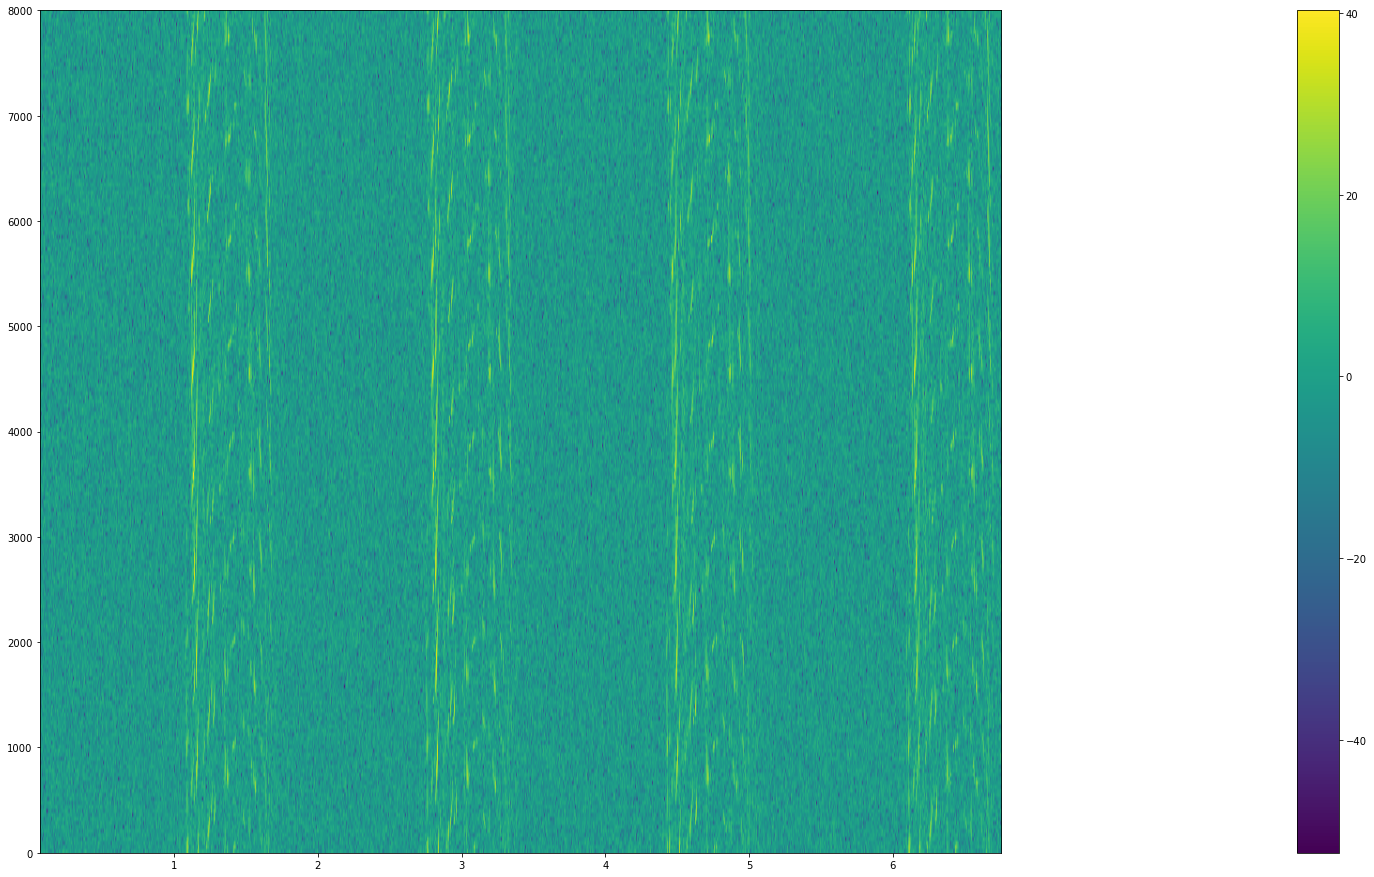

In [225]:
plot_spectrogram_nostft(s, v_time_frame_all[0], v_freq_all[0])

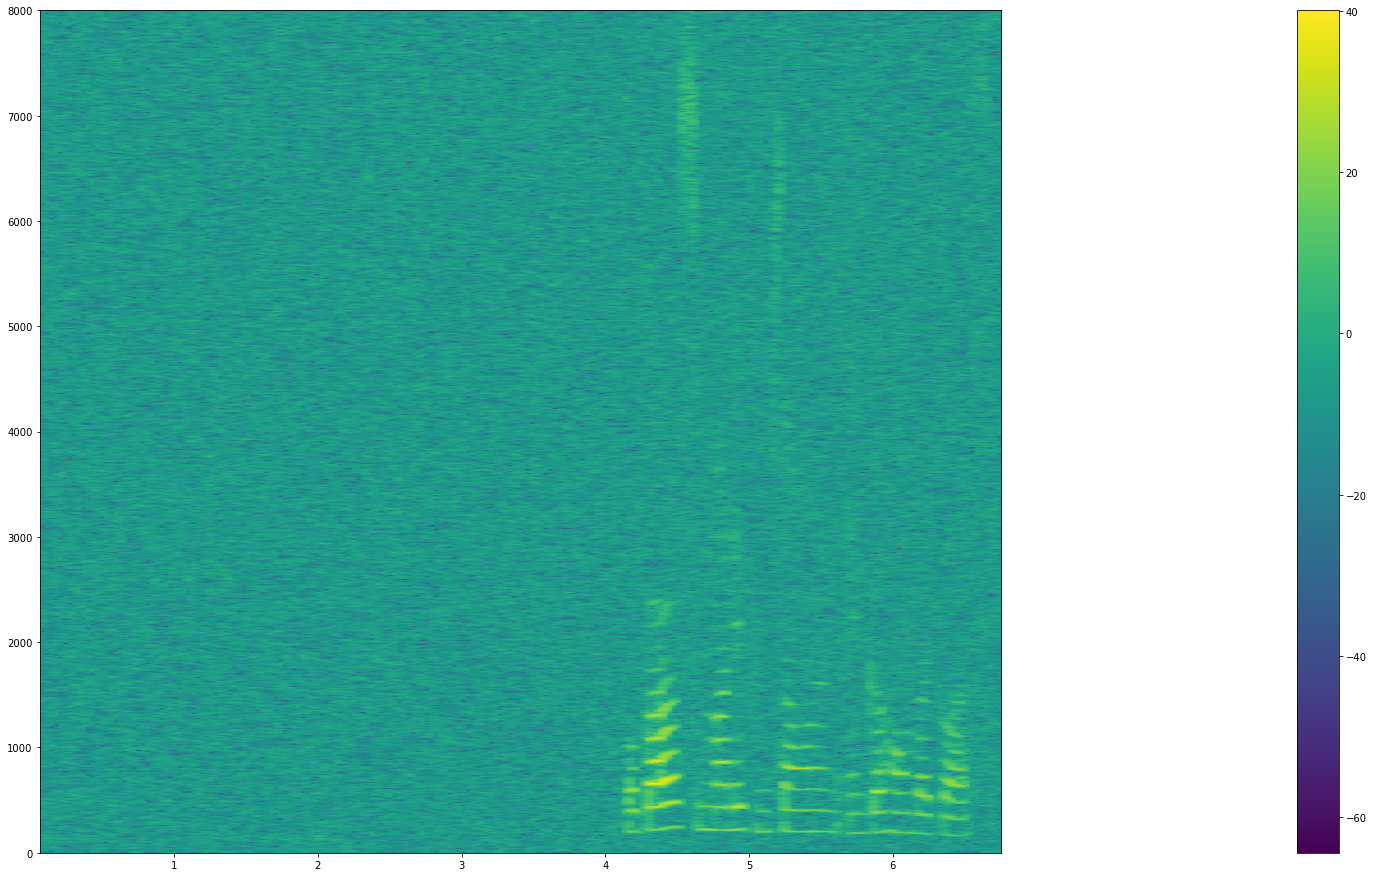

In [213]:
plot_spectrogram_nostft(m_stft_all[0], v_time_frame_all[0], v_freq_all[0])

In [184]:
m_stft_all[0].shape

(210, 1025)